In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/50
64/64 [==============================] - 47s 713ms/step - loss: 0.0375
Epoch 2/50
64/64 [==============================] - 42s 657ms/step - loss: 0.0067
Epoch 3/50
64/64 [==============================] - 44s 686ms/step - loss: 0.0054
Epoch 4/50
64/64 [==============================] - 42s 648ms/step - loss: 0.0049
Epoch 5/50
64/64 [==============================] - 42s 660ms/step - loss: 0.0045
Epoch 6/50
64/64 [==============================] - 44s 689ms/step - loss: 0.0042
Epoch 7/50
64/64 [==============================] - 49s 764ms/step - loss: 0.0040
Epoch 8/50
64/64 [==============================] - 44s 672ms/step - loss: 0.0038
Epoch 9/50
64/64 [==============================] - 44s 689ms/step - loss: 0.0037
Epoch 10/50
64/64 [==============================] - 46s 712ms/step - loss: 0.0036
Epoch 11/50
64/64 [==============================] - 44s 684ms/step - loss: 0.0035
Epoch 12/50
64/64 [==============================] - 44s 682ms/step - loss: 0.0033
Epoch 13/50
6

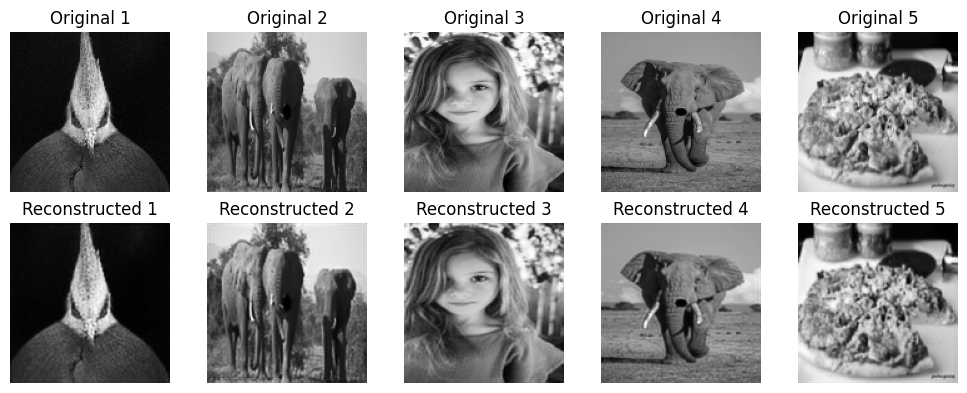

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to load and preprocess images from a folder
def load_images(folder_path, label):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:  # Check if image is loaded successfully
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            img = img.astype('float32') / 255.0  # Normalize pixel values
            images.append((img, label))  # Include the label (0 for real, 1 for faulted)
        else:
            print(f"Warning: Failed to load image {img_path}")
    return images

# Function to create and compile the autoencoder model
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_layer, decoded)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Mean Squared Error loss

    return model

# Function to visualize original and reconstructed images
def visualize_images(original_images, reconstructed_images, num_samples=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Original Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i].reshape(128, 128), cmap='gray')
        plt.title(f'Original {i + 1}')
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
        plt.title(f'Reconstructed {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load real and faulty images
real_images_path = "/content/drive/MyDrive/BTP2_/dataset"
faulty_images_path = "/content/drive/MyDrive/BTP2_/defected_images"

real_images = load_images(real_images_path, label=0)  # Label 0 for real images
faulty_images = load_images(faulty_images_path, label=1)  # Label 1 for faulted images

# Combine the datasets
all_images = real_images + faulty_images
np.random.shuffle(all_images)

# Split into input and target arrays
input_data = np.array([item[0] for item in all_images])
target_data = np.array([item[0] for item in all_images])

# Build and train the autoencoder
input_shape = (128, 128, 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.fit(input_data, target_data, epochs=50, batch_size=32, shuffle=True)

# Visualize original and reconstructed images
reconstructed_images = autoencoder.predict(input_data)
visualize_images(input_data, reconstructed_images)

# Save the trained model
autoencoder.save('autoencoder_model.h5')